In [1]:
import re
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.performance import *
from alphalens.plotting import *
from alphalens.tears import *

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

## AlphaLens

In [3]:
performance = pd.read_pickle('single_factor.pickle')

In [4]:
prices = pd.concat([df.to_frame(d) for d, df in performance.prices.items()],axis=1).T
prices.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in prices.columns]
prices.index = prices.index.normalize()
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 to 2017-12-29
Columns: 1649 entries, A to ZTS
dtypes: float64(1649)
memory usage: 9.5 MB


In [5]:
factor_data = pd.concat([df.to_frame(d) for d, df in performance.factor_data.items()],axis=1).T
factor_data.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in factor_data.columns]
factor_data.index = factor_data.index.normalize()
factor_data = factor_data.stack()
factor_data.index.names = ['date', 'asset']
factor_data.head()

date                       asset
2015-01-02 00:00:00+00:00  A        2618.0
                           AAL      1088.0
                           AAP       791.0
                           AAPL     2917.0
                           ABBV     2952.0
dtype: float64

In [6]:
with pd.HDFStore('../00_data/assets.h5') as store:
    sp500 = store['sp500/prices'].close
sp500 = sp500.resample('D').ffill().tz_localize('utc').filter(prices.index.get_level_values(0))
sp500.head()

date
2015-01-02 00:00:00+00:00    2058.20
2015-01-05 00:00:00+00:00    2020.58
2015-01-06 00:00:00+00:00    2002.61
2015-01-07 00:00:00+00:00    2025.90
2015-01-08 00:00:00+00:00    2062.14
Name: close, dtype: float64

In [15]:
HOLDING_PERIODS = (5, 10, 21, 42)
QUANTILES = 5
alphalens_data = get_clean_factor_and_forward_returns(factor=factor_data,
                                                      prices=prices,
                                                      periods=HOLDING_PERIODS,
                                                      quantiles=QUANTILES)

Dropped 14.7% entries from factor data: 14.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [16]:
alphalens_data.head()

5D       10D       21D       42D  \
date                      asset                                           
2015-01-02 00:00:00+00:00 A     -0.018738 -0.011095 -0.046105  0.052761   
                          AAL   -0.000649 -0.080319 -0.096272 -0.103877   
                          AAP   -0.013181  0.002334 -0.016335 -0.023903   
                          AAPL  -0.028172 -0.000732  0.085064  0.180737   
                          ABBV  -0.018819 -0.001973 -0.078768 -0.082410   

                                 factor  factor_quantile  
date                      asset                           
2015-01-02 00:00:00+00:00 A      2618.0                4  
                          AAL    1088.0                2  
                          AAP     791.0                1  
                          AAPL   2917.0                5  
                          ABBV   2952.0                5

### Summary Tear Sheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,1067.0,305.535714,189.870100,128886,20.043201
2,336.0,1704.0,851.172613,241.578479,128455,19.976176
3,774.0,2235.0,1407.919172,271.315212,128482,19.980375
4,1251.0,2629.0,1970.136336,263.386563,128455,19.976176
5,1794.0,3056.0,2512.624224,230.124891,128763,20.024073


Returns Analysis


,5D,10D,21D,42D
Ann. alpha,0.036,0.033,0.011,-0.001
beta,0.064,0.079,0.064,0.016
Mean Period Wise Return Top Quantile (bps),6.346,7.090,3.258,-0.771
Mean Period Wise Return Bottom Quantile (bps),-14.600,-11.865,-4.957,-1.571
Mean Period Wise Spread (bps),20.946,18.968,8.246,0.805


Information Analysis


,5D,10D,21D,42D
IC Mean,0.021,0.025,0.015,0.001
IC Std.,0.144,0.130,0.120,0.120
Risk-Adjusted IC,0.145,0.191,0.127,0.010
t-stat(IC),3.861,5.107,3.396,0.266
p-value(IC),0.000,0.000,0.001,0.790
IC Skew,0.384,0.251,0.115,0.134
IC Kurtosis,0.019,-0.584,-0.353,-0.494


Turnover Analysis


,10D,21D,42D,5D
Quantile 1 Mean Turnover,0.587,0.826,0.828,0.410
Quantile 2 Mean Turnover,0.737,0.801,0.810,0.644
Quantile 3 Mean Turnover,0.764,0.803,0.808,0.679
Quantile 4 Mean Turnover,0.737,0.803,0.808,0.641
Quantile 5 Mean Turnover,0.565,0.802,0.809,0.393


,5D,10D,21D,42D
Mean Factor Rank Autocorrelation,0.713,0.454,-0.011,-0.016


<Figure size 432x288 with 0 Axes>

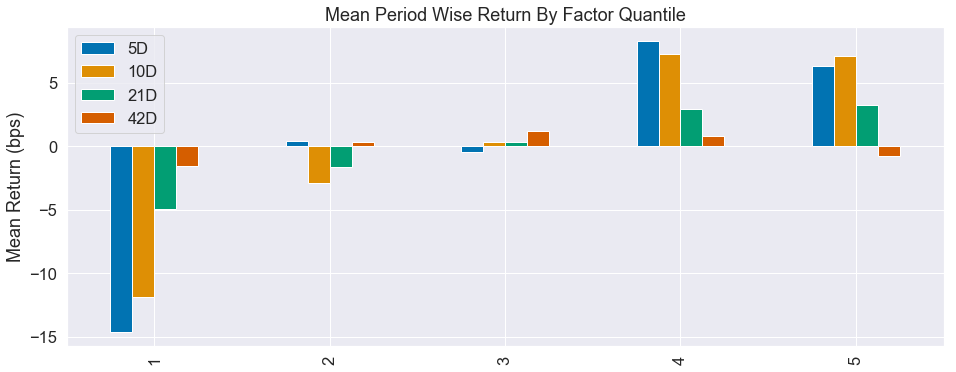

In [17]:
create_summary_tear_sheet(alphalens_data)

### Returns Analysis

In [18]:
mean_return_by_q, std_err = mean_return_by_quantile(alphalens_data)
mean_return_by_q_norm = mean_return_by_q.apply(lambda x: x.add(1).pow(1/int(x.name[:-1])).sub(1))

#### Mean Return by Holding Period and Quintile

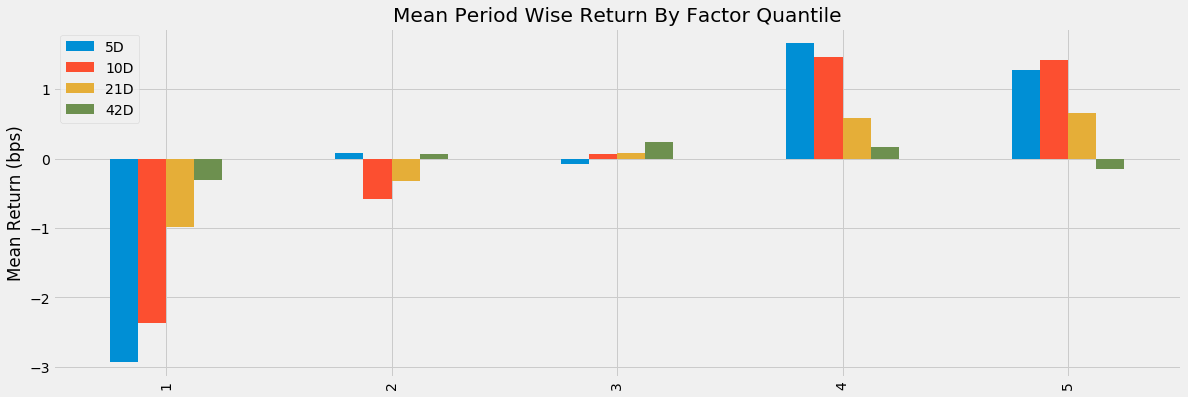

In [28]:
plot_quantile_returns_bar(mean_return_by_q_norm)
# plt.savefig('mean_return', dpi=300);

In [20]:
mean_return_by_q_daily, std_err = mean_return_by_quantile(alphalens_data, by_date=True)

#### Cumulative 5D Return

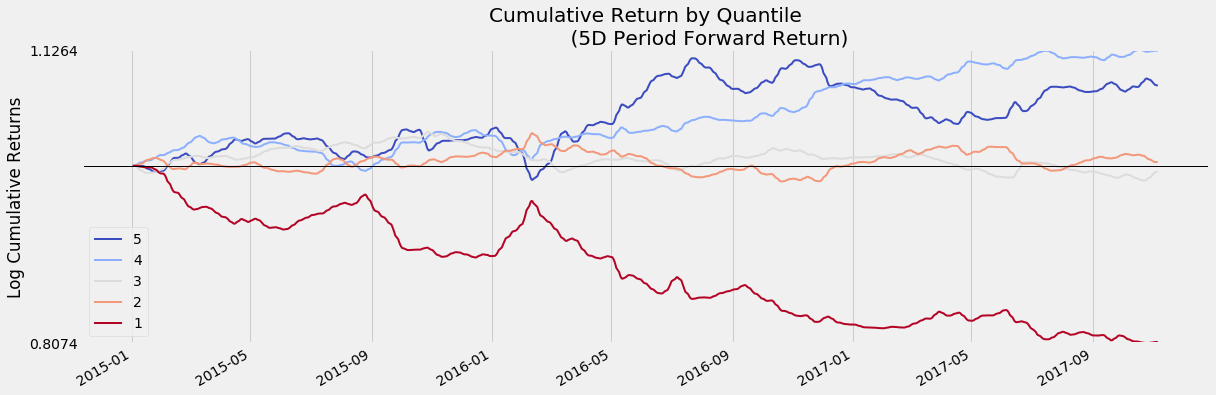

In [21]:
plot_cumulative_returns_by_quantile(mean_return_by_q_daily['5D'], period='5D')

#### Return Distribution by Holding Period and Quintile

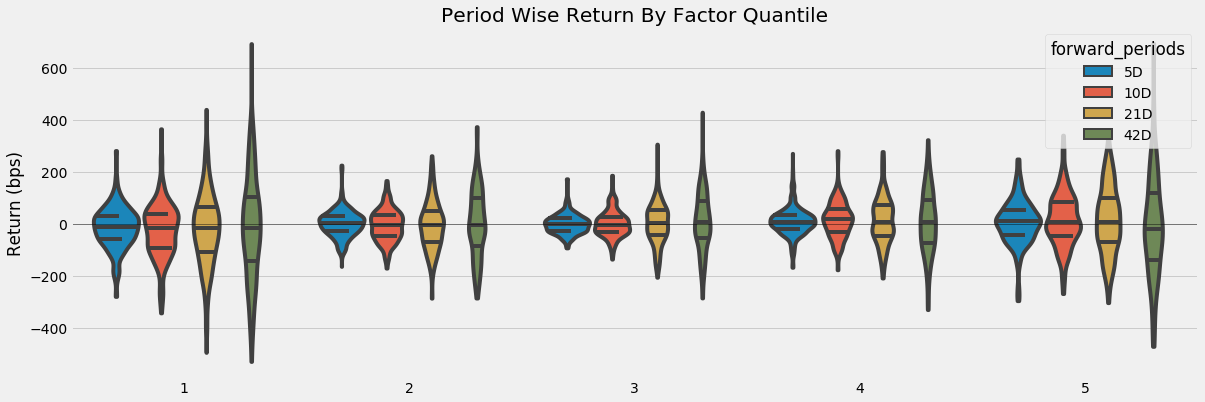

In [22]:
plot_quantile_returns_violin(mean_return_by_q_daily)
plt.savefig('mean_ret', dpi=300);

### Information Coefficient

#### 5D Information Coefficient (Rolling Average)

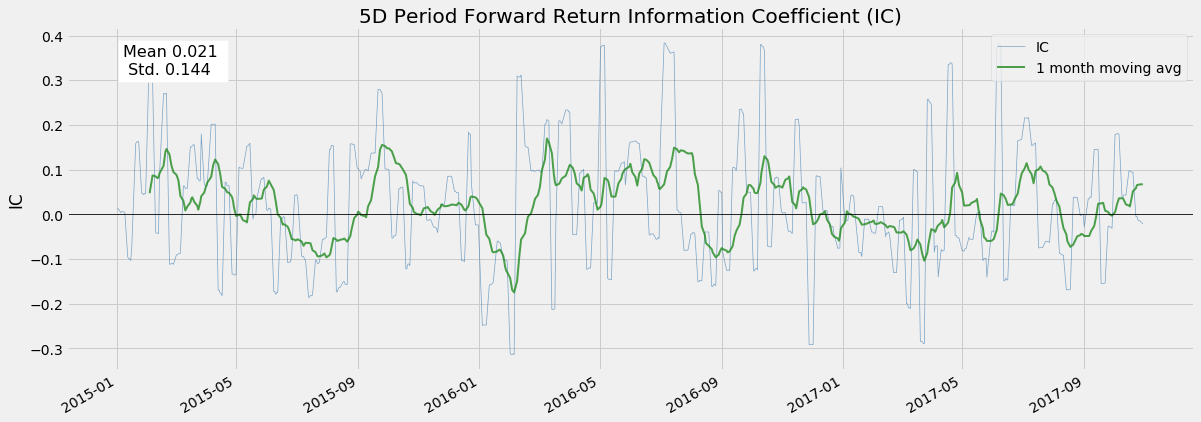

In [23]:
ic = factor_information_coefficient(alphalens_data)
plot_ic_ts(ic[['5D']])
plt.savefig('violin', dpi=300);

#### Information Coefficient by Holding Period

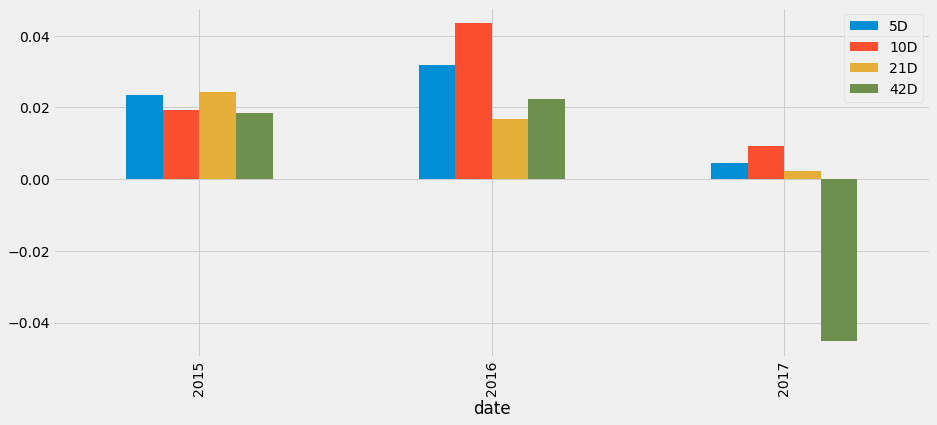

In [25]:
ic = factor_information_coefficient(alphalens_data)
ic_by_year = ic.resample('A').mean()
ic_by_year.index = ic_by_year.index.year
ic_by_year.plot.bar(figsize=(14, 6))
plt.savefig('ic', dpi=300);

### Summary Tear Sheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,1067.0,305.535714,189.870100,128886,20.043201
2,336.0,1704.0,851.172613,241.578479,128455,19.976176
3,774.0,2235.0,1407.919172,271.315212,128482,19.980375
4,1251.0,2629.0,1970.136336,263.386563,128455,19.976176
5,1794.0,3056.0,2512.624224,230.124891,128763,20.024073


Returns Analysis


,5D,10D,21D,42D
Ann. alpha,0.036,0.033,0.011,-0.001
beta,0.064,0.079,0.064,0.016
Mean Period Wise Return Top Quantile (bps),6.346,7.090,3.258,-0.771
Mean Period Wise Return Bottom Quantile (bps),-14.600,-11.865,-4.957,-1.571
Mean Period Wise Spread (bps),20.946,18.968,8.246,0.805


Information Analysis


,5D,10D,21D,42D
IC Mean,0.021,0.025,0.015,0.001
IC Std.,0.144,0.130,0.120,0.120
Risk-Adjusted IC,0.145,0.191,0.127,0.010
t-stat(IC),3.861,5.107,3.396,0.266
p-value(IC),0.000,0.000,0.001,0.790
IC Skew,0.384,0.251,0.115,0.134
IC Kurtosis,0.019,-0.584,-0.353,-0.494


Turnover Analysis


,10D,21D,42D,5D
Quantile 1 Mean Turnover,0.587,0.826,0.828,0.410
Quantile 2 Mean Turnover,0.737,0.801,0.810,0.644
Quantile 3 Mean Turnover,0.764,0.803,0.808,0.679
Quantile 4 Mean Turnover,0.737,0.803,0.808,0.641
Quantile 5 Mean Turnover,0.565,0.802,0.809,0.393


,5D,10D,21D,42D
Mean Factor Rank Autocorrelation,0.713,0.454,-0.011,-0.016


<Figure size 432x288 with 0 Axes>

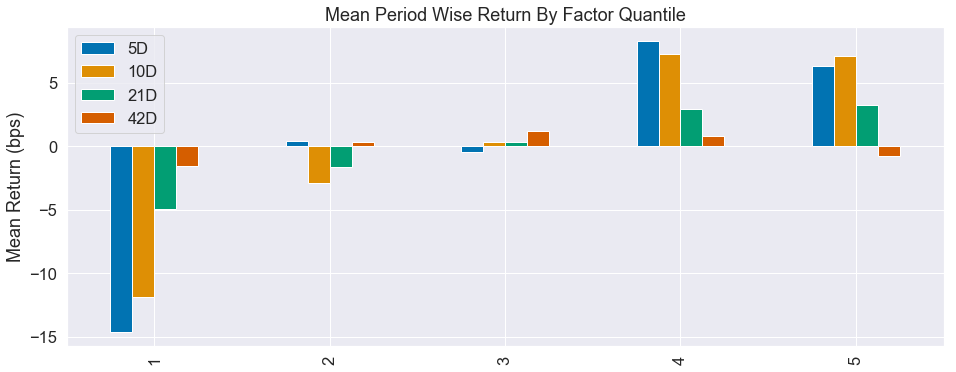

In [26]:
create_summary_tear_sheet(alphalens_data);

### Turnover Tear Sheet

Turnover Analysis


,10D,21D,42D,5D
Quantile 1 Mean Turnover,0.587,0.826,0.828,0.410
Quantile 2 Mean Turnover,0.737,0.801,0.810,0.644
Quantile 3 Mean Turnover,0.764,0.803,0.808,0.679
Quantile 4 Mean Turnover,0.737,0.803,0.808,0.641
Quantile 5 Mean Turnover,0.565,0.802,0.809,0.393


,5D,10D,21D,42D
Mean Factor Rank Autocorrelation,0.713,0.454,-0.011,-0.016


<Figure size 432x288 with 0 Axes>

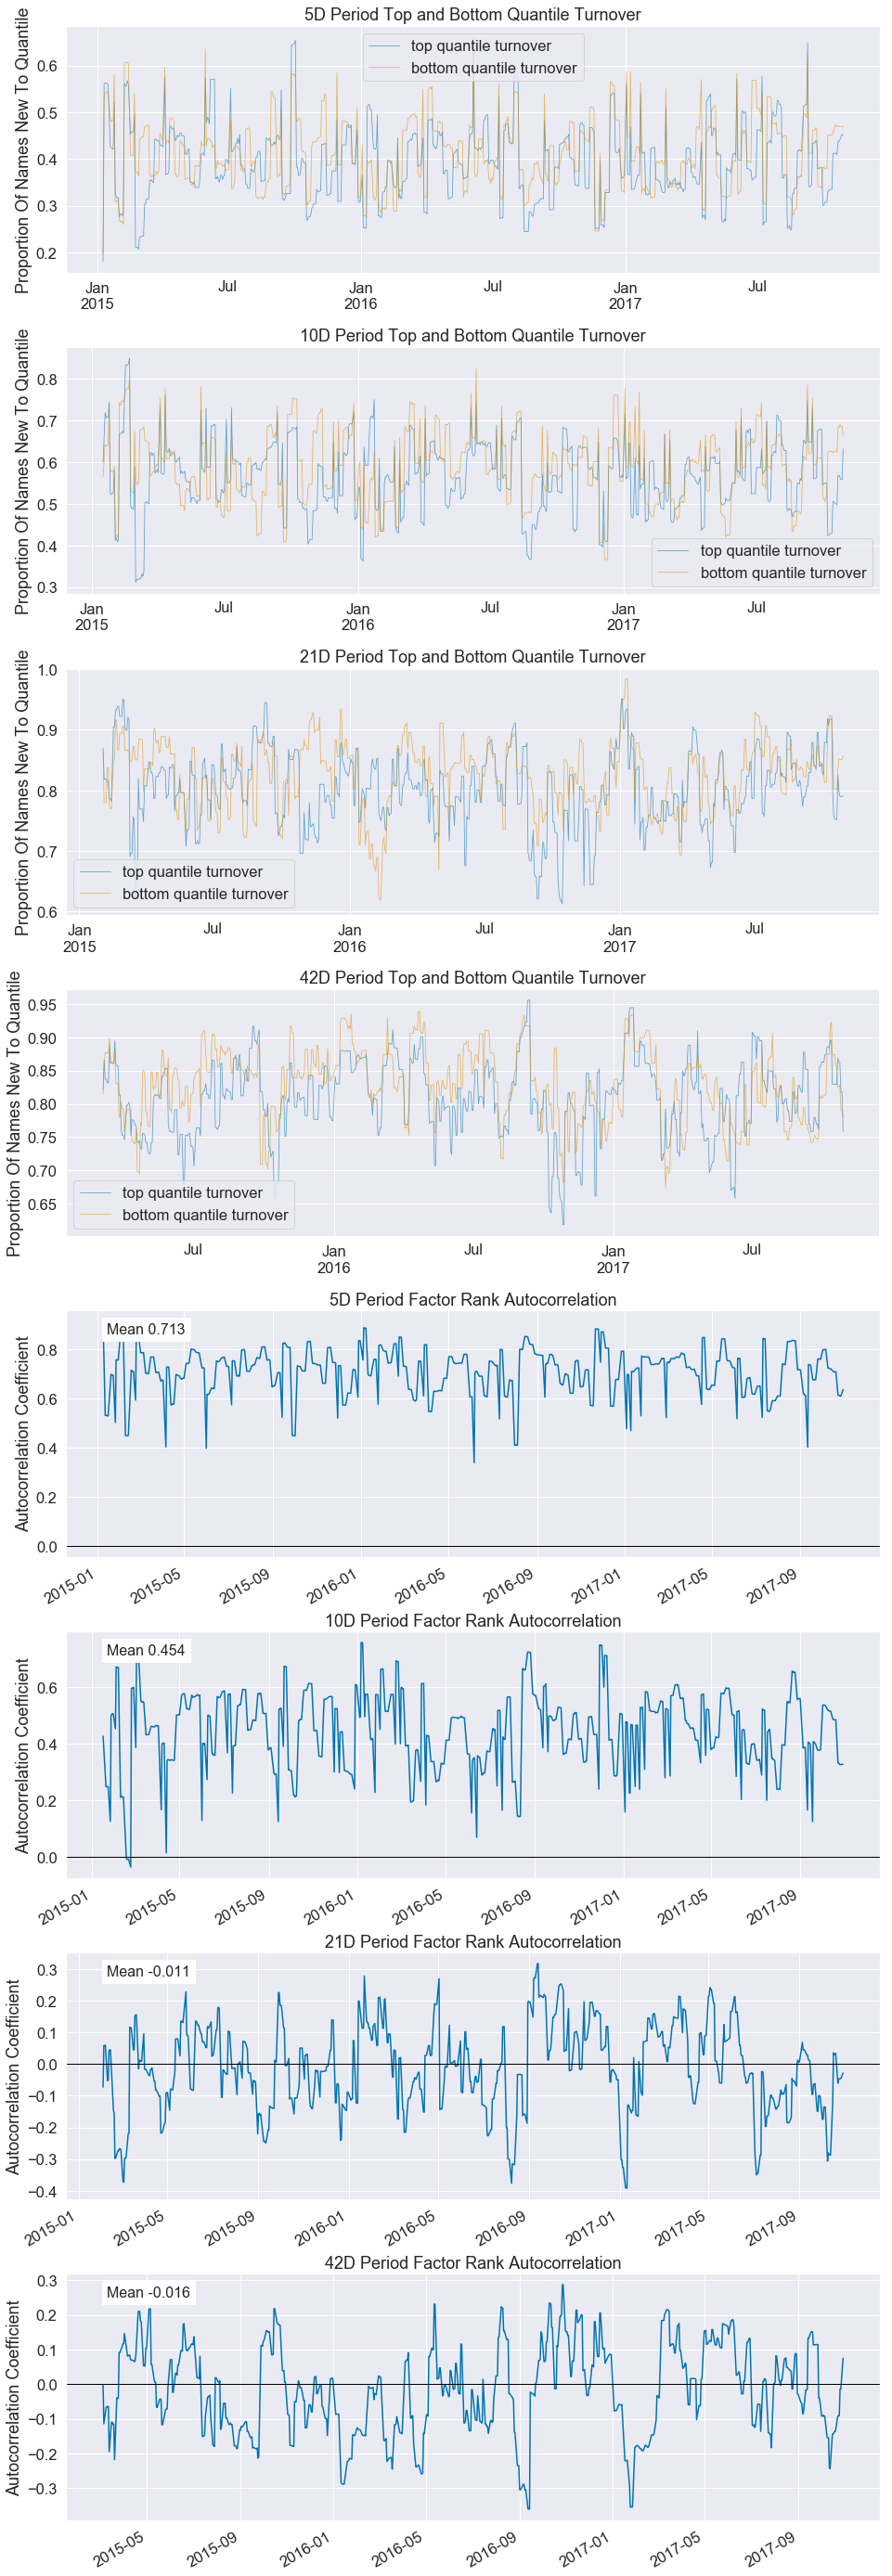

In [27]:
create_turnover_tear_sheet(alphalens_data);